In [2]:
pip install torch torchvision matplotlib numpy

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0b/fa/f33a4148c6fb46ca2a3f8de39c24d473822d5774d652b66ed9b1214da5f7/torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/29/88/00c69db213ee2443ada8886ec60789b227e06bb869d85ee324578221a7f7/torchvision-0.21.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Try different levels of noise and see how the model performs on denoising them

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading the dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train =True, transform=transform, download = True)
mnist_test = datasets.MNIST(root="./data", train= False, transform = transform, download= True)


In [3]:
#creating the dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = 64, shuffle = False)

In [4]:
def add_noise(img, noise_std = 0.3):
    noise = torch.randn_like(img) * noise_std
    return torch.clamp(img+noise, 0., 1)

def forward_diffusion(x, timesteps=10, noise_std=0.3):
    noisy_imgs= []
    for t in range(timesteps):
        x = add_noise(x, noise_std)
        noisy_imgs.append(x)
    return noisy_imgs

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(1, 32, 3, padding =1),
            nn.ReLU(),
            nn.Conv2d(32,64,3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding = 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x  = self.decoder(x)
        return x

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, ff_dim=128):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, attn_weights = self.self_attn(x, x, x, need_weights=True)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.ff(x))
        return x, attn_weights


In [7]:
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet()
        self.transformer = TransformerBlock()
        self.projection = nn.Linear(1, 64)
        self.expand = nn.Linear(64, 1)
        self.attn_weights = None

    def forward(self, x):
        x = self.unet(x)
        batch_size, _, height, width = x.shape
        x = x.view(batch_size, height * width, 1)     # [B, 784, 1]
        x = self.projection(x)                        # [B, 784, 64]
        #x, attn_weights = self.transformer(x)         # [B, 784, 64]
        #self.attn_weights = attn_weights              # [B, num_heads, 784, 784]
        x = self.expand(x)                            # [B, 784, 1]
        x = x.view(batch_size, 1, height, width)      # [B, 1, 28, 28]
        return x


In [13]:
model = DenoisingModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for images, _ in train_loader:
        noisy_images = add_noise(images)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 0.0052
Epoch [2/50], Loss: 0.0059
Epoch [3/50], Loss: 0.0044
Epoch [4/50], Loss: 0.0045
Epoch [5/50], Loss: 0.0050
Epoch [6/50], Loss: 0.0046
Epoch [7/50], Loss: 0.0053
Epoch [8/50], Loss: 0.0045
Epoch [9/50], Loss: 0.0042
Epoch [10/50], Loss: 0.0049
Epoch [11/50], Loss: 0.0046
Epoch [12/50], Loss: 0.0048
Epoch [13/50], Loss: 0.0045
Epoch [14/50], Loss: 0.0050
Epoch [15/50], Loss: 0.0047
Epoch [16/50], Loss: 0.0047
Epoch [17/50], Loss: 0.0045
Epoch [18/50], Loss: 0.0044
Epoch [19/50], Loss: 0.0043
Epoch [20/50], Loss: 0.0043
Epoch [21/50], Loss: 0.0052
Epoch [22/50], Loss: 0.0046
Epoch [23/50], Loss: 0.0046
Epoch [24/50], Loss: 0.0042
Epoch [25/50], Loss: 0.0045
Epoch [26/50], Loss: 0.0041
Epoch [27/50], Loss: 0.0044
Epoch [28/50], Loss: 0.0046
Epoch [29/50], Loss: 0.0048
Epoch [30/50], Loss: 0.0042
Epoch [31/50], Loss: 0.0043
Epoch [32/50], Loss: 0.0039
Epoch [33/50], Loss: 0.0046
Epoch [34/50], Loss: 0.0043
Epoch [35/50], Loss: 0.0041
Epoch [36/50], Loss: 0.0049
E

In [14]:
from skimage.metrics import structural_similarity as ssim

def evaluate(model, test_loader):
    model.eval()
    mse_losses = []
    ssim_scores = []

    with torch.no_grad():
        for images, _ in test_loader:
            noisy_images = add_noise(images)
            outputs = model(noisy_images)

            mse_losses.append(criterion(outputs, images).item())

            # Convert tensors to numpy
            images_np = images.squeeze().cpu().numpy()
            outputs_np = outputs.squeeze().cpu().numpy()

            # Compute SSIM with a smaller window size (win_size=3)
            ssim_value = ssim(images_np, outputs_np, data_range=1, win_size=3)

            ssim_scores.append(ssim_value)

    print(f"Mean MSE: {np.mean(mse_losses):.4f}, Mean SSIM: {np.mean(ssim_scores):.4f}")

evaluate(model, test_loader)


Mean MSE: 0.0044, Mean SSIM: 0.9029


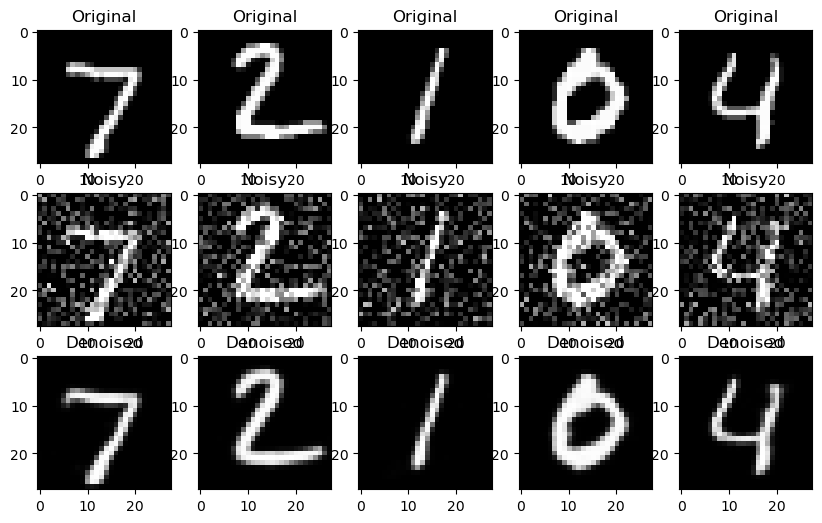

In [15]:
def visualize(model, test_loader):
    model.eval()
    images, _ = next(iter(test_loader))
    noisy_images = add_noise(images)
    
    with torch.no_grad():
        denoised_images = model(noisy_images)
    
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    for i in range(5):
        axes[0, i].imshow(images[i].squeeze(), cmap="gray")
        axes[0, i].set_title("Original")
        
        axes[1, i].imshow(noisy_images[i].squeeze(), cmap="gray")
        axes[1, i].set_title("Noisy")
        
        axes[2, i].imshow(denoised_images[i].squeeze(), cmap="gray")
        axes[2, i].set_title("Denoised")
    
    plt.show()
visualize(model, test_loader)
        

In [16]:
def visualize_attention(model, test_loader):
    model.eval()
    images, _ = next(iter(test_loader))
    noisy_images = add_noise(images)

    with torch.no_grad():
        _ = model(noisy_images)
        attn_weights = model.attn_weights  # [batch, num_heads, seq_len, seq_len]

    # Check shape
    print("Attention weight shape:", attn_weights.shape)

    # Visualize attention for first sample, first head
    plt.imshow(attn_weights[0, 0].cpu().detach(), cmap="viridis")  # [head 0, sample 0]
    plt.title("Attention Map (Head 1)")
    plt.colorbar()
    plt.show()


In [17]:
visualize_attention(model, test_loader)

AttributeError: 'NoneType' object has no attribute 'shape'